<a href="https://colab.research.google.com/github/BalamCAST/Optimizing-Liga-MX-Fixtures-with-Simulated-Annealing-and-Genetic-Algorithms/blob/main/LigaMX_Fixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de la Calendarización de la Liga MX con Algoritmos Genéticos y Recocido Simulado.

##### Diego Aranda Castañeda
##### Centro en Investigación en Ciencias
##### Instituto en Investigación en Ciencias Básicas y Aplicadas
##### Universidad Autónoma del Estado de Morelos
##### Lic. en Inteligencia Artificial
##### Búsqueda de Soluciones e Inferencia Bayesiana
##### 03 de abril de 2025

## Introducción: La Liga MX y el Desafío del Calendario.

La **Liga MX** es la máxima categoría del fútbol profesional en México, compuesta por 18 equipos que disputan dos torneos cortos al año (Apertura y Clausura). Cada torneo consta de 17 jornadas, donde los equipos se enfrentan en formato de *round-robin* (todos contra todos una vez). La complejidad de organizar el calendario radica en:
1. **Rivalidades históricas**: Partidos como el Clásico (América vs Chivas), o derbis regionales (como el Tigres vs Monterrey) atraen a millones de espectadores y requieren horarios estelares.
2. **Preferencias de horario**: Cada equipo tiene un día y hora preferidos para jugar como local (por ejemplo, el América juega mayormente los sábados a las 21:00 horas).
3. **Equilibrio competitivo**: Evitar secuencias de partidos como local/visitante consecutivos para ningún equipo.

Este código busca automatizar la generación de un calendario óptimo para uno de los dos torneos, el cuál se espera que cumpla con estos criterios, utilizando técnicas de optimización combinatoria como **recocido simulado** para distribuir los partidos y **algoritmos genéticos** para asignar horarios. El objetivo es equilibrar intereses deportivos, comerciales y logisticos, garantizando un torneo atractivo para aficionados y patrocinadores.

## 1. Configuraciones Básicas
### Variables Principales


*   NUM_EQUIPOS: Número total de equipos.
*   NUM_JORNADAS: Número de jornadas en el torneo.
*   EARLY_CUTOFF: Jornadas consideradas "tempranas" para la optimización
*   DIAS_HORARIOS: Horarios disponibles por día (Viernes, Sábado, Domingo).
*   equipos: Diccionario con información de equipos (identificador numérico, nombre, estadio, capacidad, valor)
*   rivalidades: Pares de equipos con niveles de rivalidad (0-100).
*   HORARIO_LOCAL_EQUIPO: Horario preferido de localía para cada equipo.





In [ ]:
import random
import math
import datetime
from collections import defaultdict
import copy
import time
from matplotlib import pyplot as plt
import os

NUM_EQUIPOS = 18
NUM_JORNADAS = 17
EARLY_CUTOFF = 10

DIAS_HORARIOS = {
    'Viernes': ['19:00', '21:00'],
    'Sábado': ['17:00', '19:00', '21:00'],
    'Domingo': ['12:00', '17:00', '19:00', '21:00'],
}
DIAS_ORDEN = ["Viernes", "Sábado", "Domingo"]

sorted_slots = []
for dia in DIAS_ORDEN:
    for hora in sorted(DIAS_HORARIOS[dia]):
        sorted_slots.append((dia, hora))

equipos = {
    1: ("América", "Ciudad de los Deportes", 30247, 87150000),
    2: ("Atlas", "Jalisco", 55020, 28950000),
    3: ("Atlético de San Luis", "Alfonso Lastras Ramírez", 28429, 42100000),
    4: ("Cruz Azul", "Olímpico Universitario (CU)", 58445, 91550000),
    5: ("FC Juárez", "Olímpico Benito Juárez", 19703, 34350000),
    6: ("Guadalajara", "AKRON", 46232, 67200000),
    7: ("León", "Nou Camp", 31297, 35250000),
    8: ("Mazatlán FC", "El Encanto", 20195, 33000000),
    9: ("Monterrey", "BBVA", 53529, 79000000),
    10: ("Necaxa", "Victoria", 23851, 43900000),
    11: ("Pachuca", "Hidalgo", 25922, 47850000),
    12: ("Puebla", "Cuauhtémoc", 47704, 24900000),
    13: ("Pumas", "Olímpico Universitario (CU)", 58445, 45950000),
    14: ("Querétaro", "La Corregidora", 34107, 20650000),
    15: ("Santos Laguna", "TSM Corona", 29101, 34400000),
    16: ("Tigres", "Universitario", 41886, 67400000),
    17: ("Tijuana", "Caliente", 29533, 34150000),
    18: ("Toluca", "Nemesio Diez", 27273, 71950000)
}

rivalidades = {
    ("América", "Guadalajara"): 100,
    ("Tigres", "Monterrey"): 80,
    ("América", "Pumas"): 80,
    ("Guadalajara", "Atlas"): 80,
    ("América", "Cruz Azul"): 80,
    ("Pumas", "Cruz Azul"): 80,
    ("América", "Tigres"): 50,
    ("Guadalajara", "Pumas"): 50,
    ("Guadalajara", "Cruz Azul"): 50,
    ("Atlético de San Luis", "Querétaro"): 50,
    ("Querétaro", "Atlas"): 50,
    ("León", "Querétaro"): 50,
    ("Toluca", "Santos Laguna"): 50,
    ("Atlético de San Luis", "Necaxa"): 50
}

HORARIO_LOCAL_EQUIPO = {
    "América": ("Sábado", "21:00"),
    "Atlas": ("Viernes", "21:00"),
    "Atlético de San Luis": ("Sábado", "17:00"),
    "Cruz Azul": ("Sábado", "21:00"),
    "FC Juárez": ("Viernes", "21:00"),
    "Guadalajara": ("Sábado", "19:00"),
    "León": ("Domingo", "19:00"),
    "Mazatlán FC": ("Viernes", "19:00"),
    "Monterrey": ("Sábado", "19:00"),
    "Necaxa": ("Viernes", "19:00"),
    "Pachuca": ("Domingo", "21:00"),
    "Puebla": ("Viernes", "19:00"),
    "Pumas": ("Domingo", "12:00"),
    "Querétaro": ("Viernes", "17:00"),
    "Santos Laguna": ("Domingo", "19:00"),
    "Tigres": ("Sábado", "19:00"),
    "Tijuana": ("Sábado", "19:00"),
    "Toluca": ("Domingo", "12:00")
}

## 2. Funciones Auxiliares
1. obtener_rivalidad(equipo1, equipo2)
  *   **Proposito:** Obtener el nivel de rivalidad entre dos equipos.
  *   **Retorna:** Valor numérico (20 si no hay rivalidad definida).
2. es_rivalidad_fuerte(equipo1, equipo2)
  *   **Propósito:** Determinar si la rivalidad es alta (=>80)
  *   **Retorna:** True/False




In [ ]:
def obtener_rivalidad(equipo1, equipo2):
    return rivalidades.get((equipo1, equipo2), rivalidades.get((equipo2, equipo1), 20))

def es_rivalidad_fuerte(equipo1, equipo2):
    return obtener_rivalidad(equipo1, equipo2) >= 80

## 3. Generación del Calendario (Round-Robin)
1. generar_calendario_round_robin()
  *   **Propósito**: Genera un calendario inicial usando el método _round-robin_.
  *   **Funcionamiento:**
    1.   Mezcla los IDs de los equipos
    2.   Crea jornadas alternando localías para asegurar equilibrio.
  *   Retorna: Lista de jornadas con partidos (local, visitante, horario).
2. enfrentamientos_son_unicos(schedule)
  *   **Propósito:** Verifica que no haya enfrentamientos repetidos en el calendario.
  *  **Retorna:** True si todos los enfrentamientos son únicos. False en caso contrario.







In [ ]:
def generar_calendario_round_robin():
    equipos_ids = list(equipos.keys())
    random.shuffle(equipos_ids)  # Mezclar equipos antes de generar el calendario
    n = len(equipos_ids)
    calendario = []
    for ronda in range(n - 1):
        partidos = []
        for i in range(n // 2):
            if i == 0:
                eq1 = equipos_ids[0]
                eq2 = equipos_ids[-1]
            else:
                eq1 = equipos_ids[i]
                eq2 = equipos_ids[-i - 1]
            if ronda % 2 == 0:
                partidos.append((equipos[eq1], equipos[eq2], None))
            else:
                partidos.append((equipos[eq2], equipos[eq1], None))
        calendario.append(partidos)
        equipos_ids = [equipos_ids[0]] + [equipos_ids[-1]] + equipos_ids[1:-1]
    return calendario

def enfrentamientos_son_unicos(schedule):
    enfrentamientos = set()
    for jornada in schedule:
        for partido in jornada:
            local, visitante, _ = partido
            enfrentamiento = frozenset({local[0], visitante[0]})
            if enfrentamiento in enfrentamientos:
                return False
            enfrentamientos.add(enfrentamiento)
    return True

## 4. Optimización con Recocido Simulado
1. calcular_costo(schedule)
  *   **Propósito:** Calcular el fitness del calendario basado en:
  **   Rivalidad (W1=30)
  **   Capacidad del estadio (W2=15)
  **   Valor de los equipos (W3=20)
  **   Jornada temprana/tardía (W4=25)
  **   Penalización por partidos consecutivos (W5=10)
  *  **Retorna:** Valor fitness total.
2. simulated_annealing(initial_schedule, iteraciones, temp_inicial, enfriamiento)
*   **Propósito:** Optimiza el calendario intercambiando partidos entre jornadas tempranas y tardías.
*   **Parámetros Clave:**
**   iteraciones: Número de iteraciones
**   temp_inicial:Temperatura inicial para el recocido
**   enfriamiento: Tasa de enfriamiento por iteración
*   **Proceso:**
**  1. Intercambia partidos de jornadas tempranas/tardías
**   2. Acepta cambios que mejoren el fitness o con probabilidad basada en temperatura.
**   3. Registra el historial de temperatura y fitness
*   **Retorna:** Calendario optimizado, historiales de fitness y temperatura.



In [ ]:
def calcular_costo(schedule):
    W1, W2, W3, W4, W5 = 30, 15, 20, 25, 10
    fitness = 0

    # Factores principales
    for idx_jornada, jornada in enumerate(schedule):
        jornada_num = idx_jornada + 1  # Jornadas 1-17
        J_i = (jornada_num / 17) * 100
        for partido in jornada:
            local, visitante, _ = partido
            # Rivalidad
            R_i = obtener_rivalidad(local[0], visitante[0])
            # Capacidad del estadio
            S_i = (local[2] / 58445) * 100  # Máximo: Cruz Azul (58,445)
            # Valor de los equipos
            V_i = ((local[3] + visitante[3]) / 178700000) * 100  # Suma América + Cruz Azul
            # Fitness acumulado
            fitness += W1 * R_i + W2 * S_i + W3 * V_i + W4 * J_i

    # Penalizaciones por partidos consecutivos
    consecutivos = defaultdict(str)
    penalizaciones = 0
    for idx_jornada, jornada in enumerate(schedule):
        for partido in jornada:
            local, visitante, _ = partido
            for equipo in [local[0], visitante[0]]:
                estado = 'H' if equipo == local[0] else 'A'
                if idx_jornada > 0:
                    prev_estado = consecutivos.get((equipo, idx_jornada -1), None)
                    if prev_estado == estado:
                        penalizaciones += 1
                consecutivos[(equipo, idx_jornada)] = estado
    fitness -= W5 * penalizaciones

    return fitness

def simulated_annealing(initial_schedule, iteraciones=25000, temp_inicial=10000, enfriamiento=0.995):
    current = copy.deepcopy(initial_schedule)
    current_fitness = calcular_costo(current)
    best = (copy.deepcopy(current), current_fitness)
    temp = temp_inicial

    # Historial para gráficas
    fitness_history = [current_fitness]
    temperature_history = [temp]

    for _ in range(iteraciones):
        nuevo = copy.deepcopy(current)

        # Seleccionar dos partidos de jornadas tempranas/tardías
        early_round = random.randint(0, EARLY_CUTOFF)
        late_round = random.randint(EARLY_CUTOFF + 1, NUM_JORNADAS - 1)
        idx1 = random.randint(0, len(nuevo[early_round]) - 1)
        idx2 = random.randint(0, len(nuevo[late_round]) - 1)

        partido1 = nuevo[early_round][idx1]
        partido2 = nuevo[late_round][idx2]

        # Verificar compatibilidad de equipos y enfrentamientos únicos
        equipos_partido1 = {partido1[0][0], partido1[1][0]}
        equipos_partido2 = {partido2[0][0], partido2[1][0]}
        equipos_early = obtener_equipos_en_jornada(nuevo[early_round], partido1)
        equipos_late = obtener_equipos_en_jornada(nuevo[late_round], partido2)

        # Validar que no haya solapamiento de equipos y enfrentamientos sean únicos
        if (
            equipos_partido2.isdisjoint(equipos_early)
            and equipos_partido1.isdisjoint(equipos_late)
            and enfrentamientos_son_unicos(nuevo)
        ):
            # Intercambiar partidos
            nuevo[early_round][idx1], nuevo[late_round][idx2] = partido2, partido1
            nuevo_fitness = calcular_costo(nuevo)
            delta = nuevo_fitness - current_fitness

            # Criterio de aceptación (maximización)
            if delta > 0 or random.random() < math.exp(delta / temp):
                current = copy.deepcopy(nuevo)
                current_fitness = nuevo_fitness
                if current_fitness > best[1]:
                    best = (copy.deepcopy(current), current_fitness)

        # Enfriar temperatura
        temp *= enfriamiento
        fitness_history.append(current_fitness)
        temperature_history.append(temp)

    return best[0], fitness_history, temperature_history

# Función auxiliar para obtener equipos en una jornada
def obtener_equipos_en_jornada(jornada, excluir_partido=None):
    equipos = set()
    for partido in jornada:
        if partido == excluir_partido:
            continue
        local_nombre = partido[0][0]
        visitante_nombre = partido[1][0]
        equipos.add(local_nombre)
        equipos.add(visitante_nombre)
    return equipos

## 5. Asignación de Horarios con Algoritmos Genéticos
1. ordenamiento_genetico (partidos_jornada, población, generaciones)
*  **Propósito:** Asigna horarios a partidos de una jornada maximizando el uso de horarios preferidos.
*  **Funcionamiento:**
** Población: Permutaciones de partidos.
** Fitness: Número de horarios preferidos asignados.
** Operadores: Cruce (crossover) y mutación para evolucionar soluciones.
* **Retorna:** Lista ordenada de partidos con horarios óptimos.

2. asignar_horarios_ga(calendario, fecha_inicial)
* **Propósito:** Asigna fechas y horarios a todo el calendario.
* **Proceso:**
**  Ordena partidos por jornada usando ordenamiento_genetico.
** Asigna slots disponibles priorizando horarios preferidos.
** Genera fechas reales basadas en fecha_inicial.
*  **Retorna:** Calendario completo con horarios y fechas.

In [ ]:
def ordenamiento_genetico(partidos_jornada, poblacion_size=100, generaciones=500):
    def fitness(individuo):
        slots_usados = set()
        count = 0
        for idx in individuo:
            partido = partidos_jornada[idx]
            local = partido[0]
            preferido = HORARIO_LOCAL_EQUIPO.get(local[0], None)
            if preferido and preferido not in slots_usados:
                count +=1
                slots_usados.add(preferido)
        return count

    def crossover(p1, p2):
        size = len(p1)
        a, b = sorted(random.sample(range(size), 2))
        hijo = [-1]*size
        hijo[a:b] = p1[a:b]
        pos = set(hijo[a:b])
        idx = 0
        for i in range(size):
            if hijo[i] == -1:
                while p2[idx % size] in pos:
                    idx +=1
                hijo[i] = p2[idx % size]
                idx +=1
        return hijo

    def mutate(individuo):
        a, b = random.sample(range(len(individuo)), 2)
        individuo[a], individuo[b] = individuo[b], individuo[a]
        return individuo

    poblacion = []
    for _ in range(poblacion_size):
        ind = list(range(len(partidos_jornada)))
        random.shuffle(ind)
        poblacion.append(ind)

    for _ in range(generaciones):
        poblacion.sort(key=lambda x: -fitness(x))
        poblacion = poblacion[:poblacion_size//2]
        while len(poblacion) < poblacion_size:
            p1, p2 = random.sample(poblacion, 2)
            hijo = crossover(p1, p2)
            if random.random() < 0.1:
                hijo = mutate(hijo)
            poblacion.append(hijo)

    mejor = max(poblacion, key=lambda x: fitness(x))
    return [partidos_jornada[i] for i in mejor]

def asignar_horarios_ga(calendario, fecha_inicial=datetime.date(2025, 1, 10)):
    calendario_con_horarios = []
    dia_offsets = {dia: idx for idx, dia in enumerate(DIAS_ORDEN)}
    fecha_base = fecha_inicial

    for jornada in calendario:
        partidos = [p for p in jornada]
        partidos_ordenados = ordenamiento_genetico(partidos)
        slots_disponibles = sorted_slots.copy()
        slots_asignados = {}
        for partido in partidos_ordenados:
            local = partido[0]
            preferido = HORARIO_LOCAL_EQUIPO.get(local[0], None)
            if preferido and preferido in slots_disponibles:
                slot = preferido
                slots_disponibles.remove(preferido)
            else:
                slot = slots_disponibles.pop(0)
            slots_asignados[partido] = slot

        nueva_jornada = []
        for partido in jornada:
            local, visitante, _ = partido
            slot = slots_asignados[partido]
            dia, hora = slot
            fecha_partido = fecha_base + datetime.timedelta(days=dia_offsets[dia])
            nuevo_partido = (local, visitante, None, (dia, hora, fecha_partido))
            nueva_jornada.append(nuevo_partido)
        calendario_con_horarios.append(nueva_jornada)
        fecha_base += datetime.timedelta(weeks=1)
    return calendario_con_horarios

## 6. Visualización y Guardado
1. imprimir_y_guardar_calendario(calendario_con_horarios, archivo)
*   **Propósito:** Generar un archivo de texto con el calendario optimizado.
*   **Formato:**

*JORNADA 6 (14/02/2025)
14/02/2025 - Viernes 19:00: Querétaro vs Toluca | Estadio: La Corregidora
16/02/2025 - Domingo 19:00: León vs Pachuca | Estadio: Nou Camp
16/02/2025 - Domingo 12:00: Cruz Azul vs Atlético de San Luis | Estadio:    Olímpico Universitario (CU)
15/02/2025 - Sábado 17:00: Santos Laguna vs Tijuana | Estadio: TSM Corona
15/02/2025 - Sábado 19:00: Guadalajara vs Atlas | Estadio: AKRON
16/02/2025 - Domingo 21:00: Mazatlán FC vs Puebla | Estadio: El Encanto
15/02/2025 - Sábado 21:00: América vs Necaxa | Estadio: Ciudad de los Deportes
16/02/2025 - Domingo 17:00: Monterrey vs Tigres | Estadio: BBVA
14/02/2025 - Viernes 21:00: FC Juárez vs Pumas | Estadio: Olímpico Benito Juárez*


2. graficar_convergencia(temperature_history)
*   **Propósito:** Muestra una gráfica de la temperatura durante el recocido simulado.

### Métricas clave
*   Variación relativa: Diferencia entre ejecuciones (ideal <5%)

In [ ]:
def imprimir_y_guardar_calendario(calendario_con_horarios, archivo="calendario_optimizado.txt"):
    salida = f"Calendario del Torneo\n\n"
    for jornada_num, jornada in enumerate(calendario_con_horarios, 1):
        fecha_jornada = jornada[0][-1][2]
        salida += f"\n JORNADA {jornada_num} ({fecha_jornada.strftime('%d/%m/%Y')})\n"
        for partido in jornada:
            local, visitante, _, (dia, hora, fecha) = partido
            linea = f"  {fecha.strftime('%d/%m/%Y')} - {dia} {hora}: {local[0]} vs {visitante[0]} | Estadio: {local[1]}\n"
            salida += linea
    with open(archivo, 'w', encoding='utf-8') as f:
        f.write(salida)

def graficar_convergencia(temperature_history):
  plt.figure(figsize=(12,6))
  plt.plot(temperature_history, 'b-', label='Temperatura')
  plt.xlabel('Iteración')
  plt.ylabel('Temperatura')
  plt.title('Convergencia de la Temperatura')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

fitness_finales = []
for _ in range(10):
    _, hist, _ = simulated_annealing(generar_calendario_round_robin())
    fitness_finales.append(hist[-1])

print("Fitness máximo:", max(fitness_finales))
print("Fitness mínimo:", min(fitness_finales))
print("Variación relativa:", (max(fitness_finales) - min(fitness_finales)) / max(fitness_finales))


Fitness máximo: 626875.4195860324
Fitness mínimo: 624246.3837403652
Variación relativa: 0.004193872918806368


## 7. Flujo de Ejecución
1. **Generación inicial:** Crea un calendario round-robin
2. **Optimización:** Mejora el calendario con recocido simulado
3. **Asignación de Horarios:** Usa algoritmos genéticos por jornada
4. **Resultados:** Guarda el calendario y muestra gráficos de convergencia.

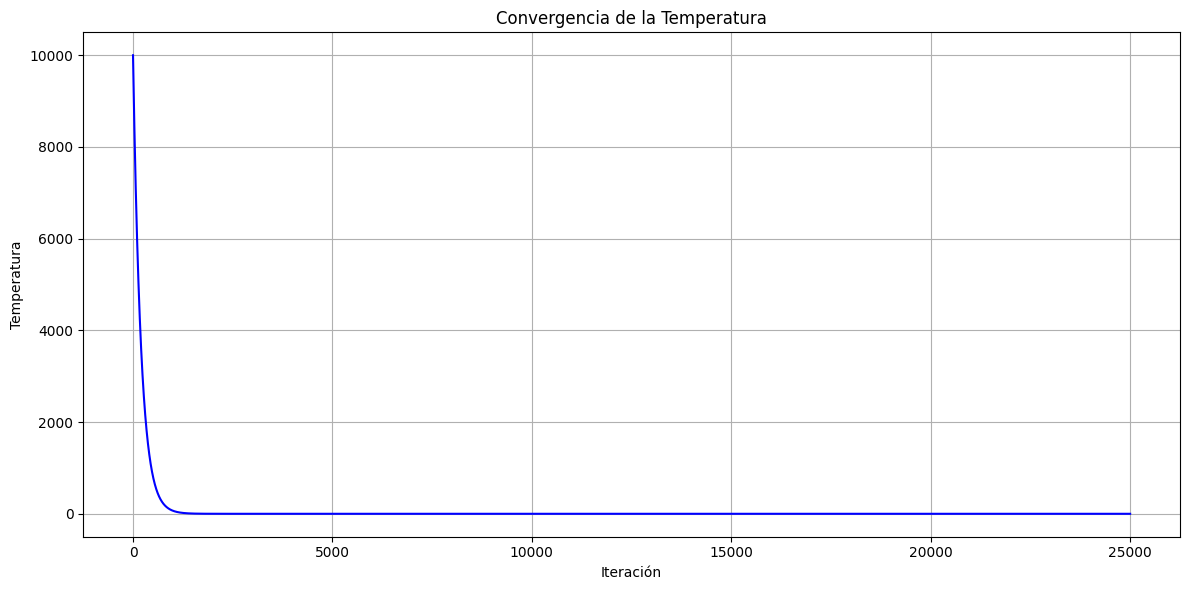

In [ ]:
if __name__ == "__main__":
    random.seed(time.time() + os.getpid())  # Semilla única por ejecución
    calendario_inicial = generar_calendario_round_robin()
    calendario_opt, fitness_hist, temp_hist = simulated_annealing(calendario_inicial)
    calendario_con_horarios = asignar_horarios_ga(calendario_opt)
    graficar_convergencia(temp_hist)
    imprimir_y_guardar_calendario(calendario_con_horarios)